In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [2]:
train_path = "../data/raw/spider_classification/train"
val_path = "../data/raw/spider_classification/valid"

In [3]:
# Image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
NUM_CLASSES = 15

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2185 images belonging to 15 classes.


In [6]:
val_generator = datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 75 images belonging to 15 classes.


In [7]:
# =====================
# Compute Class Weights
# =====================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

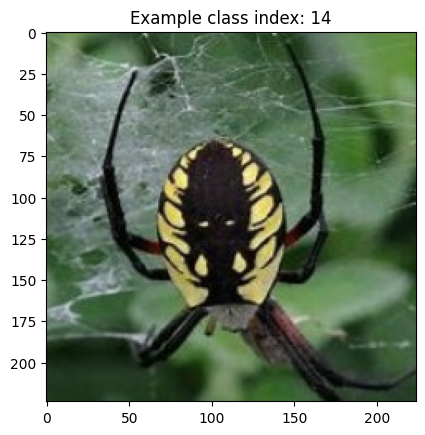

In [8]:
x_batch, y_batch = next(train_generator)
plt.imshow(x_batch[0])
plt.title(f"Example class index: {np.argmax(y_batch[0])}")
plt.show()


In [31]:
input_shape = (224, 224, 3)

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

In [32]:
from keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [34]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [35]:
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1
)

In [36]:
# =====================
# Train Model
# =====================
history = model.fit(train_generator, epochs=20, validation_data=val_generator, batch_size=32)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - accuracy: 0.0930 - loss: 2.8349 - val_accuracy: 0.2400 - val_loss: 2.2475
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.2400 - loss: 2.3271 - val_accuracy: 0.4000 - val_loss: 1.7738
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.3898 - loss: 1.9239 - val_accuracy: 0.4667 - val_loss: 1.8108
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.4935 - loss: 1.5606 - val_accuracy: 0.5200 - val_loss: 1.5040
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.5925 - loss: 1.2869 - val_accuracy: 0.4533 - val_loss: 1.4769
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.6588 - loss: 1.0635 - val_accuracy: 0.5733 - val_loss: 1.1527
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.7377 - loss: 0.8163 - val_accuracy: 0.6533 - val_loss: 1.0656
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.7981 - loss: 0.6013 - val_accuracy:

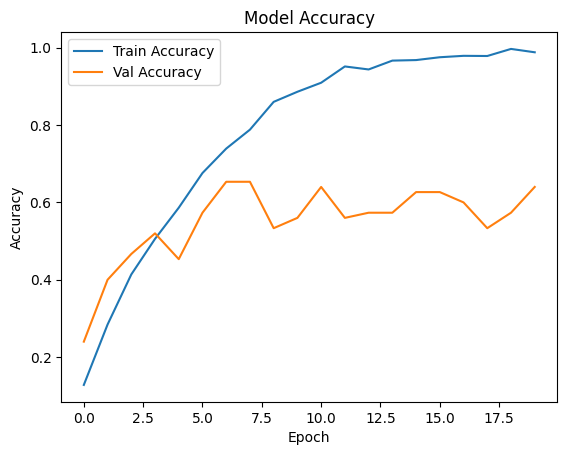

In [37]:
# =====================
# Plot Performance
# =====================
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

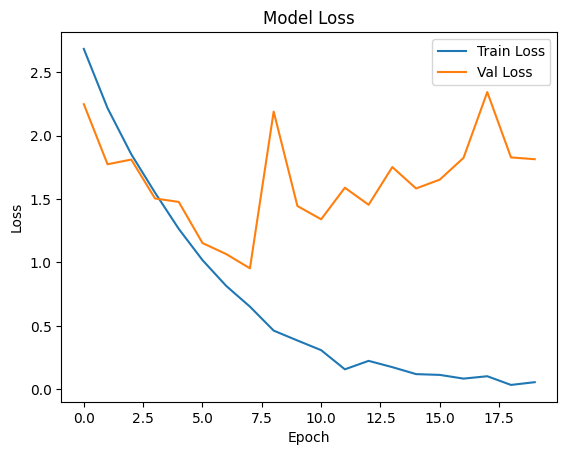

In [38]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
print("\nLoading best model for evaluation...")
best_model = load_model("best_model.keras")
val_preds = best_model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())


Loading best model for evaluation...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


In [40]:
# Get predictions on validation set
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)           # predicted class indices
y_true = val_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [41]:
# Get class labels
labels = list(val_generator.class_indices.keys())

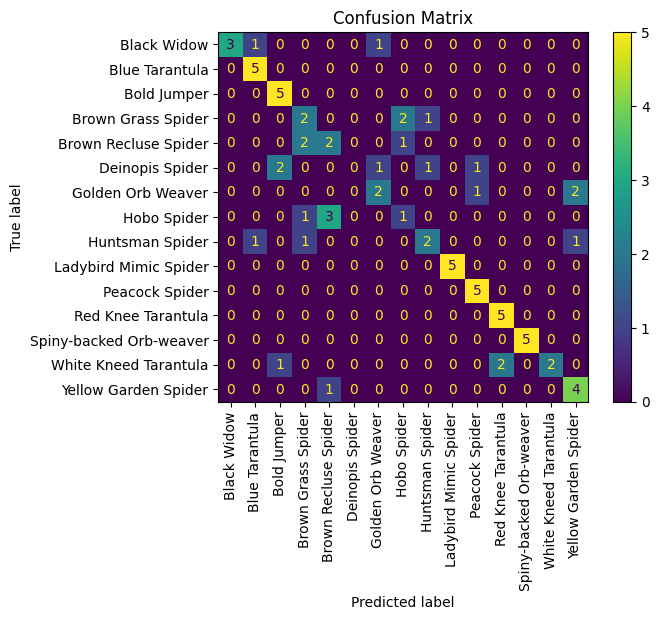

In [42]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [43]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

Classification Report:
                         precision    recall  f1-score   support

            Black Widow       1.00      0.60      0.75         5
         Blue Tarantula       0.71      1.00      0.83         5
            Bold Jumper       0.62      1.00      0.77         5
     Brown Grass Spider       0.33      0.40      0.36         5
   Brown Recluse Spider       0.33      0.40      0.36         5
        Deinopis Spider       0.00      0.00      0.00         5
      Golden Orb Weaver       0.50      0.40      0.44         5
            Hobo Spider       0.25      0.20      0.22         5
        Huntsman Spider       0.50      0.40      0.44         5
  Ladybird Mimic Spider       1.00      1.00      1.00         5
         Peacock Spider       0.71      1.00      0.83         5
     Red Knee Tarantula       0.71      1.00      0.83         5
Spiny-backed Orb-weaver       1.00      1.00      1.00         5
  White Kneed Tarantula       1.00      0.40      0.57         5
 

In [44]:
import numpy as np
print("Classes predicted:", np.unique(y_pred))
print("Classes in validation set:", np.unique(y_true))

Classes predicted: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14]
Classes in validation set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [45]:
import collections
print("Predicted class distribution:")
print(collections.Counter(y_pred))

Predicted class distribution:
Counter({np.int64(2): 8, np.int64(1): 7, np.int64(10): 7, np.int64(14): 7, np.int64(11): 7, np.int64(3): 6, np.int64(4): 6, np.int64(9): 5, np.int64(12): 5, np.int64(6): 4, np.int64(8): 4, np.int64(7): 4, np.int64(0): 3, np.int64(13): 2})


In [46]:
print(collections.Counter(train_generator.classes))

Counter({np.int32(2): 189, np.int32(14): 177, np.int32(8): 168, np.int32(1): 160, np.int32(10): 157, np.int32(12): 154, np.int32(6): 153, np.int32(7): 152, np.int32(4): 140, np.int32(3): 136, np.int32(11): 127, np.int32(13): 126, np.int32(0): 122, np.int32(5): 120, np.int32(9): 104})


In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,580,704 (21.29 MB)

 Trainable params: 2,790,351 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,790,353 (10.64 MB)

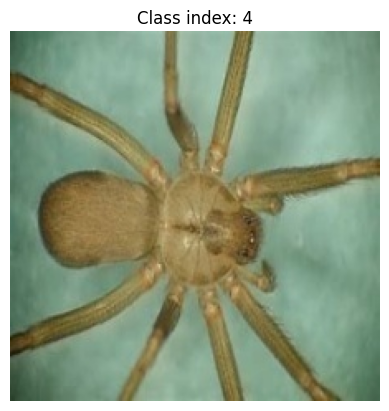

In [48]:
x_batch, y_batch = next(train_generator)

import matplotlib.pyplot as plt
plt.imshow(x_batch[0])  # Check image appearance
plt.title(f"Class index: {np.argmax(y_batch[0])}")
plt.axis("off")
plt.show()

In [49]:
small_train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

model.fit(small_train_generator, steps_per_epoch=1, epochs=10)

Found 2185 images belonging to 15 classes.
Epoch 1/10


C:\Users\Owner\PycharmProjects\tarantula-species-image-classifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 1.0000 - loss: 0.0184
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 1.0000 - loss: 0.0085
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 0.0088
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0047
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 0.0115


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


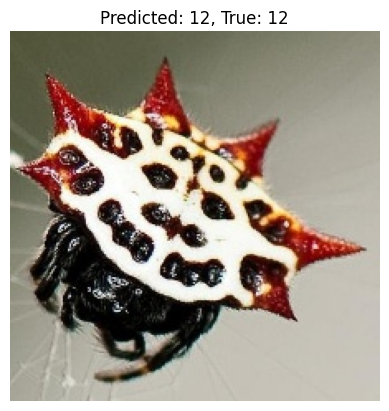

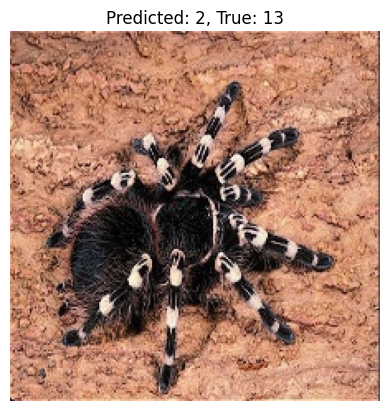

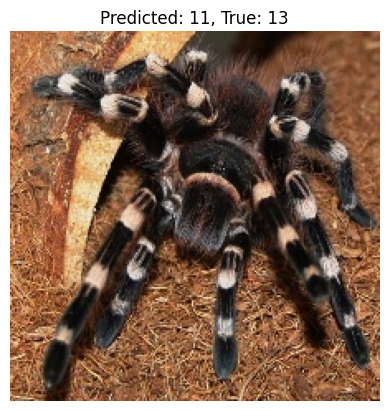

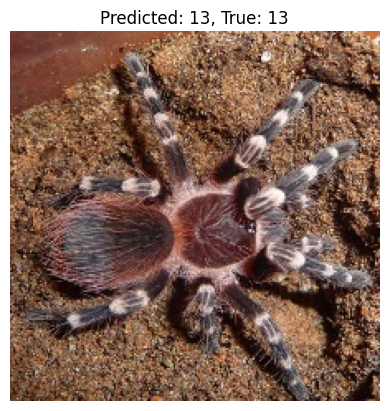

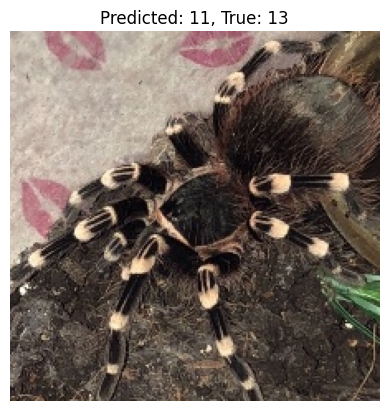

In [50]:
x, y = next(val_generator)
preds = model.predict(x)
for i in range(5):
    plt.imshow(x[i])
    plt.title(f"Predicted: {np.argmax(preds[i])}, True: {np.argmax(y[i])}")
    plt.axis("off")
    plt.show()